# Import Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pathlib import Path
import warnings
from IPython.display import Markdown, display
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

-------------

# Extract , Transform , Load

In [2]:
xlsx_dir = Path("C:\\Users\\theon\\Desktop\\London_Breakout\\London_Breakout")
output_dir = xlsx_dir.parent / "csv_propre"
output_dir.mkdir(exist_ok=True)

def extract_out_transactions(xlsx_path: Path) -> pd.DataFrame:
    df_raw = pd.read_excel(xlsx_path, sheet_name=0, header=None)
    start_row = df_raw[df_raw.iloc[:, 0].astype(str).str.contains("Transactions", na=False)].index[0]
    df = pd.read_excel(xlsx_path, sheet_name=0, skiprows=start_row + 1)
    return df[df["Direction"] == "out"].reset_index(drop=True)

# Boucle sur chaque fichier
for xlsx_file in xlsx_dir.glob("*.xlsx"):
    df_out = extract_out_transactions(xlsx_file)
    
    # Nom de sortie nettoyé
    clean_name = xlsx_file.stem.replace(" ", "_") + "_out.csv"
    output_file = output_dir / clean_name
    
    df_out.to_csv(output_file, index=False)
    print(f"✅ {output_file.name} exporté dans : {output_dir}")

✅ DE_2022_2025_1_out.csv exporté dans : C:\Users\theon\Desktop\London_Breakout\csv_propre
✅ DE_2022_2025_2_out.csv exporté dans : C:\Users\theon\Desktop\London_Breakout\csv_propre
✅ DE_2022_2025_3_out.csv exporté dans : C:\Users\theon\Desktop\London_Breakout\csv_propre
✅ EU_2022_2025_1_out.csv exporté dans : C:\Users\theon\Desktop\London_Breakout\csv_propre
✅ EU_2022_2025_2_out.csv exporté dans : C:\Users\theon\Desktop\London_Breakout\csv_propre
✅ EU_2022_2025_3_out.csv exporté dans : C:\Users\theon\Desktop\London_Breakout\csv_propre
✅ GJ_2022_2025_1_out.csv exporté dans : C:\Users\theon\Desktop\London_Breakout\csv_propre
✅ GJ_2022_2025_2_out.csv exporté dans : C:\Users\theon\Desktop\London_Breakout\csv_propre
✅ GLD_2022_2025_1_out.csv exporté dans : C:\Users\theon\Desktop\London_Breakout\csv_propre
✅ GLD_2022_2025_2_out.csv exporté dans : C:\Users\theon\Desktop\London_Breakout\csv_propre
✅ GLD_2022_2025_3_out.csv exporté dans : C:\Users\theon\Desktop\London_Breakout\csv_propre
✅ UJ_20

---------------

# Print equity curves

In [3]:
# === Imports ===
from pathlib import Path
import pandas as pd
import plotly.graph_objects as go

# === Constantes ===
CSV_DIR = Path("C:\\Users\\theon\\Desktop\\London_Breakout\\csv_propre")  # dossier des CSVs propres
IS_OOS_DATE = pd.to_datetime("2025-03-01")  # séparation IS/OOS

# Mapping des couleurs par paire
PAIR_COLORS = {
    "EU": "blue",    # EURUSD
    "UJ": "red",     # USDJPY
    "GJ": "green",   # GBPJPY
    "GLD": "yellow", # XAUUSD
    "DE": "black"    # DAX30
}

# === Helpers ===
def detect_pair(stem: str) -> str:
    """Retourne le préfixe de paire reconnu parmi PAIR_COLORS, sinon 'OTHER'."""
    for prefix in PAIR_COLORS.keys():
        if stem.startswith(prefix):
            return prefix
    return "OTHER"

def load_csv_clean(csv_path: Path) -> pd.DataFrame:
    """Charge un CSV, normalise les colonnes Heure/Solde, nettoie et trie."""
    df = pd.read_csv(csv_path)
    if "Heure" not in df.columns or "Solde" not in df.columns:
        return pd.DataFrame(columns=["Heure", "Solde"])
    df["Heure"] = pd.to_datetime(df["Heure"], errors="coerce", utc=False)
    df = df.dropna(subset=["Heure", "Solde"]).sort_values("Heure")
    return df

def add_is_oos_vline(fig: go.Figure):
    """Ajoute une ligne verticale IS/OOS couvrant toute la hauteur du graphe."""
    fig.add_shape(
        type="line",
        x0=IS_OOS_DATE, x1=IS_OOS_DATE,
        yref="paper", y0=0, y1=1,
        line=dict(width=2, dash="dash", color="black")
    )

def nice_hover(fig: go.Figure):
    fig.update_layout(hovermode="x unified")
    for tr in fig.data:
        tr.update(hovertemplate="%{x|%Y-%m-%d %H:%M}<br>Capital: %{y:.2f} €<extra>%{fullData.name}</extra>")

# === Pré-chargement de tous les fichiers une seule fois ===
all_series = []  # liste de dicts: {stem, pair, df}
for csv_file in sorted(CSV_DIR.glob("*.csv")):
    df = load_csv_clean(csv_file)
    if df.empty:
        continue
    stem = csv_file.stem
    pair = detect_pair(stem)
    all_series.append({"stem": stem, "pair": pair, "df": df})

# === 1) Graphiques séparés par paire ===
def plot_pair(pair_prefix: str) -> go.Figure:
    fig = go.Figure()
    color = PAIR_COLORS.get(pair_prefix, "gray")

    # Ajoute chaque optimisation/fichier correspondant à la paire
    for item in all_series:
        if item["pair"] != pair_prefix:
            continue
        df = item["df"]
        name = item["stem"]
        # suffixe avec le dernier capital pour lecture rapide
        if not df["Solde"].empty:
            last_val = df["Solde"].iloc[-1]
            name = f"{name} (fin: {last_val:.0f}€)"
        fig.add_trace(go.Scatter(
            x=df["Heure"], y=df["Solde"],
            mode="lines",
            name=name,
            line=dict(color=color),
            legendgroup=pair_prefix,
            showlegend=True
        ))

    add_is_oos_vline(fig)
    fig.update_layout(
        title=f"Equity Curves – {pair_prefix} (optimisations)",
        xaxis_title="Date",
        yaxis_title="Capital (€)",
        template="plotly_white"
    )
    nice_hover(fig)
    return fig

fig_EU  = plot_pair("EU")
fig_UJ  = plot_pair("UJ")
fig_GJ  = plot_pair("GJ")
fig_GLD = plot_pair("GLD")
fig_DE  = plot_pair("DE")

fig_EU.show()
fig_UJ.show()
fig_GJ.show()
fig_GLD.show()
fig_DE.show()

# === 2) Graphique global (couleurs par paire) ===
fig_global = go.Figure()
for item in all_series:
    df = item["df"]
    pair = item["pair"]
    color = PAIR_COLORS.get(pair, "gray")
    name = item["stem"]
    if not df["Solde"].empty:
        last_val = df["Solde"].iloc[-1]
        name = f"{name} (fin: {last_val:.0f}€)"
    fig_global.add_trace(go.Scatter(
        x=df["Heure"], y=df["Solde"],
        mode="lines",
        name=name,
        line=dict(color=color),
        legendgroup=pair,
        showlegend=True
    ))

add_is_oos_vline(fig_global)
fig_global.update_layout(
    title="Equity Curves – Global",
    xaxis_title="Date",
    yaxis_title="Capital (€)",
    template="plotly_white"
)
nice_hover(fig_global)
fig_global.show()


----------------------

## Optimisation with skipping False = diversified

here we are searching for a optmize portfolio that have several pairs working in the same time and try to compare what's the best. Let's say we want to search with 3 paires with equals weight

In [4]:
# === Imports ===
from pathlib import Path
import numpy as np
import pandas as pd
from itertools import product
from IPython.display import Markdown, display

# === Paramètres globaux ===
csv_dir = Path("C:\\Users\\theon\\Desktop\\London_Breakout\\csv_propre")  # dossier des CSVs propres

DATE_IS_START = pd.Timestamp("2022-01-01")
DATE_SPLIT    = pd.Timestamp("2025-03-01")

# === Configuration ===
N_PAIRS_USED       = 5          # nombre de paires à garder (si > dispo)
MIN_WEIGHT         = 0.10       # poids minimal par paire (10%)
MAX_WEIGHT         = 0.50       # poids maximal pour une paire (50%)
N_WEIGHT_SAMPLES   = 500        # nb d'échantillons de poids à tirer
TOP_K_PER_PAIR     = 3          # top stratégies par paire (accélère)
TOP_N_RESULTS      = 5          # top portefeuilles à afficher
RANDOM_SEED        = 42
np.random.seed(RANDOM_SEED)

# === Utils ===
def detect_pair(stem: str) -> str:
    if stem.startswith("EU"): return "EU"
    if stem.startswith("UJ"): return "UJ"
    if stem.startswith("GJ"): return "GJ"
    if stem.startswith("GLD"): return "GLD"
    if stem.startswith("DE"): return "DE"
    return "OTHER"

def to_daily_equity(df: pd.DataFrame) -> pd.Series:
    if df.empty or "Heure" not in df or "Solde" not in df:
        return pd.Series(dtype=float)
    s = (
        df.dropna(subset=["Heure","Solde"])
          .sort_values("Heure")
          .groupby("Heure", as_index=False)["Solde"].last()
          .set_index("Heure")["Solde"]
    )
    return s.resample("D").last().ffill()

def portfolio_metrics(eq_vals: np.ndarray) -> dict:
    """EndCap, Return, Sharpe, MaxDD, Winrate (daily), ProfitFactor (daily)."""
    if eq_vals is None or eq_vals.size < 2:
        return dict(end=np.nan, ret=np.nan, sharpe=np.nan, maxdd=np.nan, winrate=np.nan, pf=np.nan)

    end = float(eq_vals[-1])
    ret = (end - float(eq_vals[0])) / float(eq_vals[0])

    rets = np.diff(eq_vals) / eq_vals[:-1]
    if rets.size == 0:
        sharpe = np.nan
        winrate = np.nan
        pf = np.nan
    else:
        vol = rets.std(ddof=1)
        sharpe = (rets.mean() / vol) * np.sqrt(252.0) if vol > 0 else np.nan
        winrate = (rets > 0).mean()
        gains = rets[rets > 0].sum()
        losses = rets[rets < 0].sum()  # négatif
        pf = (gains / abs(losses)) if losses < 0 else np.nan

    cummax = np.maximum.accumulate(eq_vals)
    dd = (eq_vals - cummax) / cummax
    maxdd = dd.min() if dd.size else np.nan

    return dict(end=end, ret=float(ret), sharpe=float(sharpe), maxdd=float(maxdd),
                winrate=float(winrate), pf=float(pf))

def objective(eq_vals: np.ndarray) -> float:
    """Objectif IS : ret + 0.1 * Sharpe."""
    m = portfolio_metrics(eq_vals)
    if np.isnan(m["ret"]) or np.isnan(m["sharpe"]):
        return -1e9
    return m["ret"] + 0.1 * m["sharpe"]

def random_weights_constrained(n, min_w, max_w):
    """Tire des poids (somme=1) avec min/max par paire."""
    for _ in range(10000):
        w = np.random.dirichlet(np.ones(n))
        if np.all(w >= min_w) and np.all(w <= max_w):
            return w / w.sum()
    return np.ones(n) / n  # fallback

# === Chargement IS ===
equity_IS_by_strategy = {}
pair_by_strategy = {}

for csv_file in sorted(csv_dir.glob("*.csv")):
    stem = csv_file.stem
    pair_by_strategy[stem] = detect_pair(stem)
    df = pd.read_csv(csv_file)
    if "Heure" not in df.columns or "Solde" not in df.columns:
        continue
    df["Heure"] = pd.to_datetime(df["Heure"], errors="coerce")
    sub_is = df[(df["Heure"] >= DATE_IS_START) & (df["Heure"] < DATE_SPLIT)]
    equity_IS_by_strategy[stem] = to_daily_equity(sub_is)

display(Markdown("✅ Cache equity IS construit"))

# === Paires détectées & sélection des 5 ===
all_pairs_detected = sorted(
    p for p in set(pair_by_strategy.values())
    if p not in (None, "", "OTHER")
)
PAIRS_USED = all_pairs_detected[:N_PAIRS_USED]
display(Markdown(f"🔎 Paires utilisées : **{', '.join(PAIRS_USED)}**"))

# === Stratégies valides ===
valid_strats = {
    s for s, eq in equity_IS_by_strategy.items()
    if pair_by_strategy.get(s) in PAIRS_USED and len(eq) > 3
}

# === Top-K par paire (Sharpe décroissant) ===
def sharpe_is_of(s):
    eq = equity_IS_by_strategy[s]
    vals = eq.values
    rets = np.diff(vals) / vals[:-1]
    if len(rets) < 3 or rets.std(ddof=1) == 0:
        return -1e9
    return (rets.mean() / rets.std(ddof=1)) * np.sqrt(252)

choices_per_pair = {}
for p in PAIRS_USED:
    strats_p = [s for s in valid_strats if pair_by_strategy[s] == p]
    if not strats_p:
        continue
    scored = sorted(strats_p, key=sharpe_is_of, reverse=True)
    keep = scored[:TOP_K_PER_PAIR]
    choices_per_pair[p] = keep

# === Combinaisons (1 stratégie par paire) ===
all_combos = list(product(*[choices_per_pair[p] for p in PAIRS_USED]))
print(f"Nb de combinaisons à tester : {len(all_combos)}")

# === Évaluation IS avec pondérations contraintes ===
results = []
for combo in all_combos:
    selected = list(combo)
    eqs = [equity_IS_by_strategy[s] for s in selected]
    df_merged = pd.concat(eqs, axis=1).dropna()
    if df_merged.empty:
        continue

    best_local_score = -1e9
    best_local_w     = None
    best_local_met   = None

    # Tirages de poids respectant 10%–50%
    mat = df_merged.to_numpy()
    for _ in range(N_WEIGHT_SAMPLES):
        w = random_weights_constrained(mat.shape[1], MIN_WEIGHT, MAX_WEIGHT)
        eq_vals = mat @ w
        score = objective(eq_vals)
        if score > best_local_score:
            best_local_score = score
            best_local_w     = w
            best_local_met   = portfolio_metrics(eq_vals)

    results.append({
        "pairs": ", ".join(sorted({pair_by_strategy[s] for s in selected})),
        "strategies": ", ".join(selected),
        "weights": dict(zip(selected, best_local_w)),
        "EndCap": best_local_met["end"],
        "Return": best_local_met["ret"],
        "Sharpe": best_local_met["sharpe"],
        "MaxDD": best_local_met["maxdd"],
        "Winrate": best_local_met["winrate"],
        "PF": best_local_met["pf"],
        "score": best_local_score
    })

# === Top 5 portefeuilles ===
df_results = pd.DataFrame(results)
df_top = df_results.sort_values("score", ascending=False).head(TOP_N_RESULTS)

def fmt_weights(d):
    return ", ".join([f"{k}:{v:.1%}" for k,v in d.items()])

df_top["weights"] = df_top["weights"].apply(fmt_weights)

display(Markdown("### 🏆 Top 5 portfolios (5 pairs, constrained weights, IS only)"))
display(
    df_top[[
        "pairs","strategies","weights",
        "EndCap","Return","Sharpe","MaxDD","Winrate","PF","score"
    ]].style.format({
        "EndCap":  "{:,.0f} €",
        "Return":  "{:.2%}",
        "Sharpe":  "{:.2f}",
        "MaxDD":   "{:.2%}",
        "Winrate": "{:.1%}",
        "PF":      "{:.2f}",
        "score":   "{:.4f}"
    })
)


✅ Cache equity IS construit

🔎 Paires utilisées : **DE, EU, GJ, GLD, UJ**

Nb de combinaisons à tester : 162


### 🏆 Top 5 portfolios (5 pairs, constrained weights, IS only)

--------------

# check the corr for diversified portfolio 

### 🔗 Corrélation **globale** entre composants (rendements journaliers, full période)

DE_2022_2025_3_out  EU_2022_2025_1_out  \
DE_2022_2025_3_out                1.000               0.008   
EU_2022_2025_1_out                0.008               1.000   
GJ_2022_2025_2_out                0.081               0.068   
GLD_2022_2025_1_out               0.010               0.152   
UJ_2022_2025_1_out               -0.060               0.055   

                     GJ_2022_2025_2_out  GLD_2022_2025_1_out  \
DE_2022_2025_3_out                0.081                0.010   
EU_2022_2025_1_out                0.068                0.152   
GJ_2022_2025_2_out                1.000                0.062   
GLD_2022_2025_1_out               0.062                1.000   
UJ_2022_2025_1_out                0.127                0.129   

                     UJ_2022_2025_1_out  
DE_2022_2025_3_out               -0.060  
EU_2022_2025_1_out                0.055  
GJ_2022_2025_2_out                0.127  
GLD_2022_2025_1_out               0.129  
UJ_2022_2025_1_out                1.000

### ⚠️ Corrélation **conditionnelle** quand le portefeuille est en perte (`r_port < 0`)

DE_2022_2025_3_out  EU_2022_2025_1_out  \
DE_2022_2025_3_out                1.000              -0.111   
EU_2022_2025_1_out               -0.111               1.000   
GJ_2022_2025_2_out               -0.013              -0.129   
GLD_2022_2025_1_out              -0.183              -0.037   
UJ_2022_2025_1_out               -0.108              -0.096   

                     GJ_2022_2025_2_out  GLD_2022_2025_1_out  \
DE_2022_2025_3_out               -0.013               -0.183   
EU_2022_2025_1_out               -0.129               -0.037   
GJ_2022_2025_2_out                1.000               -0.163   
GLD_2022_2025_1_out              -0.163                1.000   
UJ_2022_2025_1_out               -0.166               -0.030   

                     UJ_2022_2025_1_out  
DE_2022_2025_3_out               -0.108  
EU_2022_2025_1_out               -0.096  
GJ_2022_2025_2_out               -0.166  
GLD_2022_2025_1_out              -0.030  
UJ_2022_2025_1_out                1.000

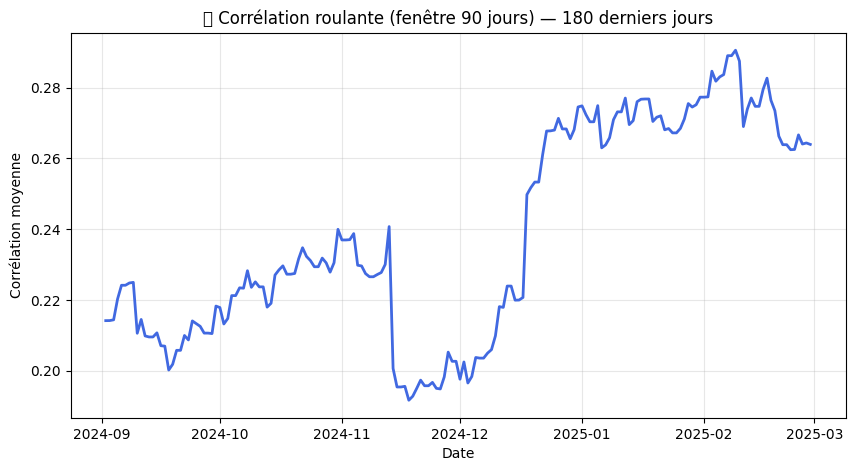

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Sélection des séries à analyser (par exemple celles du meilleur portefeuille) ===
best_portfolio = df_top.iloc[0]
selected_strats = [s.strip() for s in best_portfolio["strategies"].split(",")]

# === 2. Construction du DataFrame des équities normalisées ===
eq_df = pd.concat([equity_IS_by_strategy[s] for s in selected_strats], axis=1).dropna()
eq_df.columns = selected_strats

# === 3. Calcul des rendements journaliers ===
r_df = eq_df.pct_change().dropna()

# === 4. Corrélation globale (pleine période) ===
corr_global = r_df.corr()
display(Markdown("### 🔗 Corrélation **globale** entre composants (rendements journaliers, full période)"))
display(corr_global.round(3))

# === 5. Corrélation conditionnelle : quand le portefeuille est en perte ===
r_port = r_df.mean(axis=1)
r_df_neg = r_df.loc[r_port < 0]
corr_cond = r_df_neg.corr()

display(Markdown("### ⚠️ Corrélation **conditionnelle** quand le portefeuille est en perte (`r_port < 0`)"))
display(corr_cond.round(3))

# === 6. Corrélation roulante (fenêtre glissante 90 jours) ===
window = 90
corr_rolling = r_df.rolling(window).corr().groupby(level=0).mean()
avg_corr = corr_rolling.mean(axis=1)  # moyenne des corrélations intra-paires

# === 7. Graphique corrélation roulante ===
plt.figure(figsize=(10,5))
plt.plot(avg_corr[-180:], color='royalblue', linewidth=2)
plt.title("📉 Corrélation roulante (fenêtre 90 jours) — 180 derniers jours", fontsize=12)
plt.ylabel("Corrélation moyenne")
plt.xlabel("Date")
plt.grid(alpha=0.3)
plt.show()



Le portefeuille présente une corrélation moyenne faible (< 0,3) entre ses composantes et même négative lors des phases de pertes, traduisant une diversification robuste et stable dans le temps. Cette structure réduit efficacement le risque de concentration et améliore la résilience globale du portefeuille face aux régimes de marché variés.

-------------------

### Daily return analysis 

In [6]:
# === Analyse des performances par jour de la semaine ===

# 1. Copie et mise en forme
dow = r_port.copy()
dow.index = pd.to_datetime(dow.index)

# 2. Création du DataFrame avec le nom du jour
dow_df = (
    dow.to_frame("ret")
       .assign(dow=lambda x: x.index.day_name())
)

# 3. Agrégations statistiques
perf_dow = (
    dow_df.groupby("dow")["ret"]
    .agg(["count", "mean", "std"])
)

# 4. Winrate : % de jours positifs par jour de semaine
perf_dow["winrate"] = (
    dow_df.groupby("dow")["ret"]
    .apply(lambda s: (s > 0).mean())
)

# 5. Tri des jours selon la moyenne de performance
perf_dow = perf_dow.sort_values("mean", ascending=False)

# 6. Affichage propre
display(Markdown("### 📅 Performance par jour de la semaine"))
display(perf_dow.style.format({
    "count": "{:,.0f}",
    "mean": "{:.3%}",
    "std": "{:.3%}",
    "winrate": "{:.1%}"
}))


### 📅 Performance par jour de la semaine

Le portefeuille tend à mieux performer en milieu de semaine, avec un profil plus stable les mercredis et jeudis.
Les mardis et vendredis peuvent être considérés comme périodes plus risquées ou moins prévisibles,

---------------------

# Maximum Drawdown

In [16]:
import pandas as pd

# Rendements journaliers (r_port est déjà disponible)
# r_port est supposé contenir vos rendements quotidiens

# Définition des fenêtres glissantes en jours ouvrés
periods = {
    "1 Jour": 1,
    "1 Semaine": 5,
    "1 Mois": 21,
    "1 Trimestre": 63,
    "1 Année": 252
}

results = {}

for name, window in periods.items():
    if window == 1:
        # Pour 1 jour, c'est simplement le rendement le plus bas
        max_loss_pct = r_port.min()
    else:
        # Calcul du rendement cumulé glissant sur 'window' jours
        # (1 + R1) * (1 + R2) * ... - 1
        rolling_cumulative_return = (1 + r_port).rolling(window=window).apply(lambda x: x.prod() - 1, raw=True)
        
        # La perte maximale (le rendement le plus négatif) sur cette période
        max_loss_pct = rolling_cumulative_return.min()

    results[name] = max_loss_pct

V0 = 10000  # Valeur initiale du portefeuille (à ajuster)

# Conversion du dictionnaire de résultats en DataFrame pour un affichage propre
df_results = pd.Series(results, name="Perte Maximale (Min. Rendement)").to_frame()

# Calcul de la perte en USD/EUR
df_results["Perte Maximale (€ ou $ V0=" + str(V0) + ")"] = df_results["Perte Maximale (Min. Rendement)"] * V0

# Affichage propre
display(Markdown("### 📉 Pertes Maximales Glissantes (Worst-Case Loss)"))
display(
    df_results.style.format({
        "Perte Maximale (Min. Rendement)": "{:.3%}",
        "Perte Maximale (€ ou $ V0=" + str(V0) + ")": "€{:,.2f}"
    })
)

### 📉 Pertes Maximales Glissantes (Worst-Case Loss)

-------------------------------------------

# Monthly return

In [17]:
# === Analyse mensuelle des performances ===
# On part du rendement journalier du portefeuille : r_port (Series avec index datetime)

perf_by_month = (
    r_port.resample("M")
    .agg(["count", "mean", "std"])
    .assign(ret=lambda x: (1 + x["mean"]) ** x["count"] - 1)  # approx rendement mensuel cumulé
)

# Ajouter colonne "year_month" au format AAAA-MM
perf_by_month["year_month"] = perf_by_month.index.strftime("%Y-%m")

# === Plotly Bar Chart chronologique ===
import plotly.graph_objects as go

# Couleur verte si rendement positif, rouge sinon
colors = ["#00cc96" if val > 0 else "#EF553B" for val in perf_by_month["ret"]]

fig = go.Figure(
    data=[go.Bar(
        x=perf_by_month["year_month"],
        y=100 * perf_by_month["ret"],          # en pourcentage
        marker_color=colors,
        text=[f"{100*v:.1f}%" for v in perf_by_month["ret"]],
        textposition="outside"
    )]
)

fig.update_layout(
    title="📆 Performance mensuelle (2022–2025)",
    xaxis_title="Mois",
    yaxis_title="Rendement mensuel (%)",
    template="plotly_white",
    height=500,
    xaxis=dict(tickangle=-45, tickfont=dict(size=10)),
    showlegend=False
)

# Ligne horizontale à 0%
fig.add_hline(y=0, line_dash="dot", line_color="gray")

fig.show()


--------------

# Gain Cap Testing

In [21]:
import numpy as np

# Rendement initial (à la fin de la période sans cap)
final_return_uncapped = (1 + r_port).prod() - 1

# Définition des seuils de gain à tester (1% à 10%)
max_gains_pct = np.arange(1, 11)

results_gain_cap = {}
V_initial = 1  # Base de 1 pour le calcul du rendement cumulé

for cap_pct in max_gains_pct:
    # Convertir le pourcentage en décimal
    cap = cap_pct / 100.0
    
    # Créer une série de rendements "capés"
    # Si le rendement journalier dépasse le cap, il est ramené à 'cap'
    # Sinon, il reste le rendement réel (r_port)
    r_port_capped = r_port.copy()
    r_port_capped[r_port_capped > cap] = cap
    
    # Calculer le rendement cumulé final avec ce cap appliqué
    final_return_capped = (1 + r_port_capped).prod() - 1
    
    results_gain_cap[f"{cap_pct}%"] = final_return_capped
    
# Conversion des résultats en DataFrame pour un affichage propre
df_cap_results = pd.Series(results_gain_cap, name="Rendement Final cumulé").to_frame()

# Ajouter le rendement sans cap pour comparaison
df_cap_results.loc["Sans Cap"] = final_return_uncapped

# Affichage des résultats
display(Markdown("### 📈 Impact du Seuil de Gain Journalier (Gain Cap)"))
display(
    df_cap_results.style.format({
        "Rendement Final cumulé": "{:.2%}"
    }).background_gradient(cmap='RdYlGn', axis=0) # Pour visualiser facilement les différences
)

### 📈 Impact du Seuil de Gain Journalier (Gain Cap)

On voit donc ici que laisser la strategie faire sa vie est plus interessant

------------

# Stress and randomness testing

In [18]:
import numpy as np, pandas as pd
import plotly.graph_objects as go

# ---------- Helpers ----------
def max_drawdown_from_returns(r: pd.Series | np.ndarray, base=1.0):
    r = pd.Series(r, copy=False).fillna(0.0).to_numpy()
    eq = base * np.cumprod(1.0 + r)
    dd = eq / np.maximum.accumulate(eq) - 1.0
    return float(dd.min()), eq

def annualize(ret_series: np.ndarray):
    mu = ret_series.mean() * 252.0
    vol = ret_series.std(ddof=1) * np.sqrt(252.0)
    sharpe = mu / vol if vol > 0 else np.nan
    return mu, vol, sharpe

def block_bootstrap_returns(r: np.ndarray, n: int, block_len: int, rng: np.random.Generator):
    """Bootstrap par blocs (chemin de longueur n)."""
    if block_len <= 1:
        idx = rng.integers(0, len(r), size=n)
        return r[idx]
    n_blocks = int(np.ceil(n / block_len))
    starts = rng.integers(0, len(r) - block_len + 1, size=n_blocks)
    path = np.concatenate([r[s:s+block_len] for s in starts])[:n]
    return path

# ---------- Paramètres Monte Carlo ----------
N_SIM       = 50_000         # attention: peut être lourd; réduire à 10_000 si besoin
BLOCK_LEN   = 5              # longueur de bloc
BASE_CAP    = 10_000
SEED        = 42

r = pd.Series(r_port.dropna().astype(float))
n = len(r)
rng = np.random.default_rng(SEED)

terminal_vals = np.empty(N_SIM, dtype=float)
sim_maxdds    = np.empty(N_SIM, dtype=float)
sim_sharpes   = np.empty(N_SIM, dtype=float)

# Boucle MC (robuste et simple)
r_np = r.to_numpy()
for i in range(N_SIM):
    path = block_bootstrap_returns(r_np, n=n, block_len=BLOCK_LEN, rng=rng)
    dd_min, eq = max_drawdown_from_returns(path, base=BASE_CAP)
    terminal_vals[i] = eq[-1]
    sim_maxdds[i]    = dd_min
    _, _, sh         = annualize(path)
    sim_sharpes[i]   = sh

# ---------- Résumés ----------
p5, p50, p95 = np.percentile(terminal_vals, [5, 50, 95])
dd_p5        = np.percentile(sim_maxdds, 5)           # 5% pire drawdown
sh_p5        = np.percentile(sim_sharpes, 5)
# VaR / ES (Expected Shortfall) à 5% sur le capital final (en €)
var5_val = p5
es5_val  = terminal_vals[terminal_vals <= p5].mean()

# Probabilités utiles
prob_loss      = (terminal_vals < BASE_CAP).mean()
prob_loss_10   = (terminal_vals < 0.9 * BASE_CAP).mean()
prob_dd_20     = (sim_maxdds < -0.20).mean()

print(f"Capital final (base {BASE_CAP:,.0f}€) — P5: {p5:,.0f}€ | Médiane: {p50:,.0f}€ | P95: {p95:,.0f}€")
print(f"VaR5%: {var5_val:,.0f}€ | ES5%: {es5_val:,.0f}€")
print(f"MaxDD 5e pct: {dd_p5:.1%} | Sharpe 5e pct: {sh_p5:.2f}")
print(f"P[Cap < base] = {prob_loss:.1%} | P[Cap < base-10%] = {prob_loss_10:.1%} | P[MaxDD < -20%] = {prob_dd_20:.1%}")

# ---------- Histogrammes ----------
fig = go.Figure()
fig.add_trace(go.Histogram(x=terminal_vals, nbinsx=60, name="Capital final", opacity=0.85))
fig.add_vline(x=p5,  line_dash="dash", line_color="firebrick",  annotation_text="P5")
fig.add_vline(x=p50, line_dash="dash", line_color="black",      annotation_text="Médiane")
fig.add_vline(x=p95, line_dash="dash", line_color="seagreen",   annotation_text="P95")
fig.update_layout(title="Monte Carlo — distribution du capital final",
                  xaxis_title="Capital (€)", yaxis_title="Fréquence", template="plotly_white")
fig.show()

fig2 = go.Figure()
fig2.add_trace(go.Histogram(x=100*sim_maxdds, nbinsx=60, name="MaxDD (%)", opacity=0.85))
fig2.update_layout(title="Monte Carlo — distribution des Max Drawdowns",
                   xaxis_title="MaxDD (%)", yaxis_title="Fréquence", template="plotly_white")
fig2.show()

fig3 = go.Figure()
fig3.add_trace(go.Histogram(x=sim_sharpes, nbinsx=60, name="Sharpe simulé", opacity=0.85))
fig3.update_layout(title="Monte Carlo — distribution du Sharpe",
                   xaxis_title="Sharpe", yaxis_title="Fréquence", template="plotly_white")
fig3.show()

# ---------- Fan chart (bandes de percentiles dans le temps) ----------
# On refait des chemins pour la visualisation, avec un N plus petit pour ne pas saturer la RAM
N_PATHS_FOR_BANDS = 2_000
bands = [5, 25, 50, 75, 95]
paths_eq = np.empty((N_PATHS_FOR_BANDS, n), dtype=float)

for i in range(N_PATHS_FOR_BANDS):
    path = block_bootstrap_returns(r_np, n=n, block_len=BLOCK_LEN, rng=rng)
    _, eq = max_drawdown_from_returns(path, base=BASE_CAP)
    paths_eq[i, :] = eq

perc_curves = np.percentile(paths_eq, bands, axis=0)  # shape (len(bands), n)
dates = r.index

fig4 = go.Figure()
# Zones (P5–P95 et P25–P75)
fig4.add_traces([
    go.Scatter(x=dates, y=perc_curves[bands.index(95)], line=dict(width=0), showlegend=False),
    go.Scatter(x=dates, y=perc_curves[bands.index(5)],  fill='tonexty', name='P5–P95', opacity=0.15)
])
fig4.add_traces([
    go.Scatter(x=dates, y=perc_curves[bands.index(75)], line=dict(width=0), showlegend=False),
    go.Scatter(x=dates, y=perc_curves[bands.index(25)], fill='tonexty', name='P25–P75', opacity=0.25)
])
# Médiane
fig4.add_trace(go.Scatter(x=dates, y=perc_curves[bands.index(50)], name='Médiane', line=dict(width=2)))

fig4.update_layout(title="Monte Carlo — fan chart de l’equity (bandes de percentiles)",
                   xaxis_title="Date", yaxis_title="Capital simulé (€)", template="plotly_white", height=500)
fig4.show()


Capital final (base 10,000€) — P5: 16,182€ | Médiane: 22,576€ | P95: 31,481€
VaR5%: 16,182€ | ES5%: 14,924€
MaxDD 5e pct: -13.2% | Sharpe 5e pct: 1.15
P[Cap < base] = 0.0% | P[Cap < base-10%] = 0.0% | P[MaxDD < -20%] = 0.1%


Le backtest Monte Carlo valide la robustesse structurelle de la stratégie :

Faible probabilité de perte ou de drawdown majeur,

Rendement médian supérieur à +125 %,

Ratio de Sharpe stable et élevé.

👉 Ces résultats confirment que le portefeuille est statistiquement résilient et bien calibré en termes de risque/rendement.

--------------

In [ ]:
# =========================
# 3) IS vs OOS — "clean white" (auto-build eq_is/eq_oos)
# =========================
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# --- Choix de la courbe source ---
TARGET_STEM = None  # ex: "EU_optA_..." ; laisse None pour prendre la "meilleure" (dernier Solde max)

assert len(all_series) > 0, "Aucune série chargée dans all_series. Vérifie CSV_DIR et le parsing."

def pick_series(all_series, target_stem=None):
    if target_stem:
        for it in all_series:
            if it["stem"] == target_stem:
                return it
        raise ValueError(f"Stem '{target_stem}' introuvable. Disponibles: {[it['stem'] for it in all_series[:10]]} ...")
    # sinon: meilleure par Solde final
    best = None
    best_val = -np.inf
    for it in all_series:
        df = it["df"]
        if df.empty or "Solde" not in df or df["Solde"].empty:
            continue
        last_val = df["Solde"].iloc[-1]
        if last_val > best_val:
            best_val = last_val
            best = it
    if best is None:
        raise ValueError("Impossible de déterminer une série valide (colonnes vides ?).")
    return best

chosen = pick_series(all_series, TARGET_STEM)
df_equity = chosen["df"].copy()

# --- Construction eq_is / eq_oos ---
# Index temps propre
df_equity = df_equity.dropna(subset=["Heure", "Solde"]).sort_values("Heure")
eq = df_equity.set_index("Heure")["Solde"].astype(float)
eq.index = pd.to_datetime(eq.index)

# Date de split (tu l'as déjà définie plus haut)
split_dt = pd.to_datetime(IS_OOS_DATE).to_pydatetime()

# Découpe
eq_is  = eq[eq.index <= split_dt]
eq_oos = eq[eq.index >  split_dt]

# =========================
# Figure "clean white"
# =========================
fig = go.Figure()

# Courbe IS
if len(eq_is):
    fig.add_trace(go.Scatter(
        x=eq_is.index, y=eq_is.values,
        mode="lines",
        name="In-Sample (IS)",
        line=dict(width=2, color="#2563eb"),
        hovertemplate="IS<br>%{x|%Y-%m-%d}<br><b>%{y:,.0f} €</b><extra></extra>"
    ))

# Courbe OOS
if len(eq_oos):
    fig.add_trace(go.Scatter(
        x=eq_oos.index, y=eq_oos.values,
        mode="lines",
        name="Out-of-Sample (OOS)",
        line=dict(width=2, dash="dash", color="#f59e0b"),
        hovertemplate="OOS<br>%{x|%Y-%m-%d}<br><b>%{y:,.0f} €</b><extra></extra>"
    ))

# Zones subtiles
if len(eq_is):
    fig.add_vrect(x0=eq_is.index.min(), x1=split_dt,
                  fillcolor="#2563eb", opacity=0.04, line_width=0, layer="below")
if len(eq_oos):
    fig.add_vrect(x0=split_dt, x1=eq_oos.index.max(),
                  fillcolor="#f59e0b", opacity=0.04, line_width=0, layer="below")

# Ligne de split + annotation
fig.add_shape(
    type="line", x0=split_dt, x1=split_dt, y0=0, y1=1, xref="x", yref="paper",
    line=dict(color="rgba(0,0,0,0.35)", width=1, dash="dot")
)
fig.add_annotation(
    x=split_dt, y=1.0, yref="paper",
    text=f"Split IS / OOS — {split_dt:%Y-%m-%d}",
    showarrow=False, xanchor="left", yanchor="bottom",
    font=dict(size=11, color="rgba(0,0,0,0.55)")
)

# Mise en forme "blanche épurée"
last_name = chosen["stem"]
fig.update_layout(
    title=dict(text=f"Évolution du capital — IS vs OOS<br><sup>{last_name}</sup>", x=0.02, xanchor="left"),
    template="plotly_white",
    paper_bgcolor="white",
    plot_bgcolor="white",
    height=520,
    margin=dict(l=60, r=30, t=70, b=50),
    font=dict(family="Inter, -apple-system, Segoe UI, Roboto, Arial", size=13, color="rgba(0,0,0,0.85)"),
    hovermode="x unified",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5, bgcolor="rgba(255,255,255,0.7)"),
)

# Axes
fig.update_xaxes(showgrid=True, gridcolor="rgba(0,0,0,0.06)", zeroline=False)
fig.update_yaxes(showgrid=True, gridcolor="rgba(0,0,0,0.06)", tickformat=",.0f", ticksuffix=" €", zeroline=False)

fig.show()
